In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def generate_data_stream(steps=1000):
    """
    Simulates a data stream with seasonal variations, random noise, and injected anomalies.
    
    Parameters:
    - steps: int, optional (default=1000)
        The number of data points to generate in the stream.

    Returns:
    - data_stream: np.array
        The generated data stream containing sinusoidal patterns, noise, and random anomalies.
    """
    time = np.arange(steps)
    
    # Sinusoidal base signal with seasonal variation
    seasonal_signal = 10 * np.sin(2 * np.pi * time / 100)  
    
    # Add random noise to simulate real-world data fluctuations
    noise = np.random.normal(0, 1, steps) 
    
    # Inject random anomalies (sudden spikes)
    anomalies = np.random.choice([0, 50], size=steps, p=[0.98, 0.02])
    
    # Combine seasonal signal, noise, and anomalies
    data_stream = seasonal_signal + noise + anomalies
    
    return data_stream

In [3]:
def detect_anomalies_zscore(data_stream, window_size=50, threshold=3):
    """
    Detects anomalies in a data stream using Z-score-based analysis.
    
    Parameters:
    - data_stream: np.array
        The continuous data stream to be analyzed for anomalies.
    
    - window_size: int, optional (default=50)
        The size of the rolling window used for calculating the moving mean and standard deviation.
    
    - threshold: float, optional (default=3)
        The number of standard deviations above or below the mean to consider as an anomaly.

    Returns:
    - anomalies: list of tuples
        A list of detected anomalies where each entry is a tuple (index, value) indicating the index 
        of the anomaly in the data stream and the corresponding anomalous value.
    """
    # Deque to store a rolling window of data points
    rolling_window = deque(maxlen=window_size)
    
    # List to store detected anomalies
    anomalies = []

    for i, value in enumerate(data_stream):
        # Only calculate Z-score when the rolling window is full
        if len(rolling_window) == window_size:
            mean = np.mean(rolling_window)   # Compute mean of the rolling window
            std_dev = np.std(rolling_window) # Compute standard deviation of the rolling window

            # Calculate the Z-score for the current data point
            z_score = (value - mean) / std_dev if std_dev != 0 else 0

            # If the Z-score exceeds the threshold, mark it as an anomaly
            if abs(z_score) > threshold:
                anomalies.append((i, value))  # Store the index and value of the anomaly
        
        # Add the current value to the rolling window
        rolling_window.append(value)

    return anomalies

def zscore_anomaly_detection_optimized(data_stream, window_size=50, threshold=3):
    """
    Optimized Z-score-based anomaly detection using online calculations.
    """
    rolling_window = deque(maxlen=window_size)
    anomalies = []

    # Initialize rolling statistics
    sum_vals = 0.0
    sum_sq_vals = 0.0

    for i, value in enumerate(data_stream):
        if len(rolling_window) == window_size:
            # Compute mean and std_dev using rolling sums
            mean = sum_vals / window_size
            variance = (sum_sq_vals / window_size) - (mean ** 2)
            std_dev = np.sqrt(variance) if variance > 0 else 0

            z_score = (value - mean) / std_dev if std_dev != 0 else 0

            if abs(z_score) > threshold:
                anomalies.append((i, value))

            # Remove the oldest value from sums
            old_value = rolling_window.popleft()
            sum_vals -= old_value
            sum_sq_vals -= old_value ** 2
        else:
            # If window isn't full yet, just append
            rolling_window.append(value)
            sum_vals += value
            sum_sq_vals += value ** 2
            continue

        # Add the new value to rolling window and sums
        rolling_window.append(value)
        sum_vals += value
        sum_sq_vals += value ** 2

    return anomalies

In [17]:
def visualize_anomalies(data_stream, anomalies_list, algorithm_name):
    """
    Visualizes the data stream and highlights detected anomalies.
    
    Parameters:
    - data_stream: np.array
        The continuous data stream.
    
    - anomalies_list: list of tuples
        A list of detected anomalies from the anomaly detection algorithm.
    
    - algorithm_name: str
        The name of the anomaly detection algorithm used.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    x_data = []
    y_data = []
    anomaly_x = [idx for idx, _ in anomalies_list]
    anomaly_y = [value for _, value in anomalies_list]

    def animate(i):
        x_data.append(i)
        y_data.append(data_stream[i])
        ax.clear()
        ax.plot(x_data, y_data, label='Data Stream')
        ax.scatter(anomaly_x, anomaly_y, color='red', label='Anomalies')
        ax.set_title(f'Real-Time Anomaly Detection using {algorithm_name}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.legend(loc='upper right')
        ax.set_xlim(0, len(data_stream))
        ax.set_ylim(min(data_stream) - 10, max(data_stream) + 10)

    # Create the animation object and assign it to a variable
    ani = animation.FuncAnimation(fig, animate, frames=len(data_stream), interval=0.1, repeat=False)
    
    # Display the animation
    plt.show()
    
    # Return the animation object to prevent garbage collection
    return ani

In [9]:
def visualize_anomalies_static(data_stream, anomalies_list, algorithm_name):
    """
    Visualizes the data stream and highlights detected anomalies in a static plot.
    
    Parameters:
    - data_stream: np.array
        The continuous data stream.
    
    - anomalies_list: list of tuples
        A list of detected anomalies from the anomaly detection algorithm.
    
    - algorithm_name: str
        The name of the anomaly detection algorithm used.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the data stream
    ax.plot(data_stream, label='Data Stream')
    
    # Extract anomaly indices and values
    anomaly_x = [idx for idx, _ in anomalies_list]
    anomaly_y = [value for _, value in anomalies_list]
    
    # Highlight anomalies
    ax.scatter(anomaly_x, anomaly_y, color='red', label='Anomalies', zorder=5)
    
    # Add title and labels
    ax.set_title(f'Anomaly Detection using {algorithm_name}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    
    # Add a legend
    ax.legend(loc='upper right')
    
    # Display the plot
    plt.show()


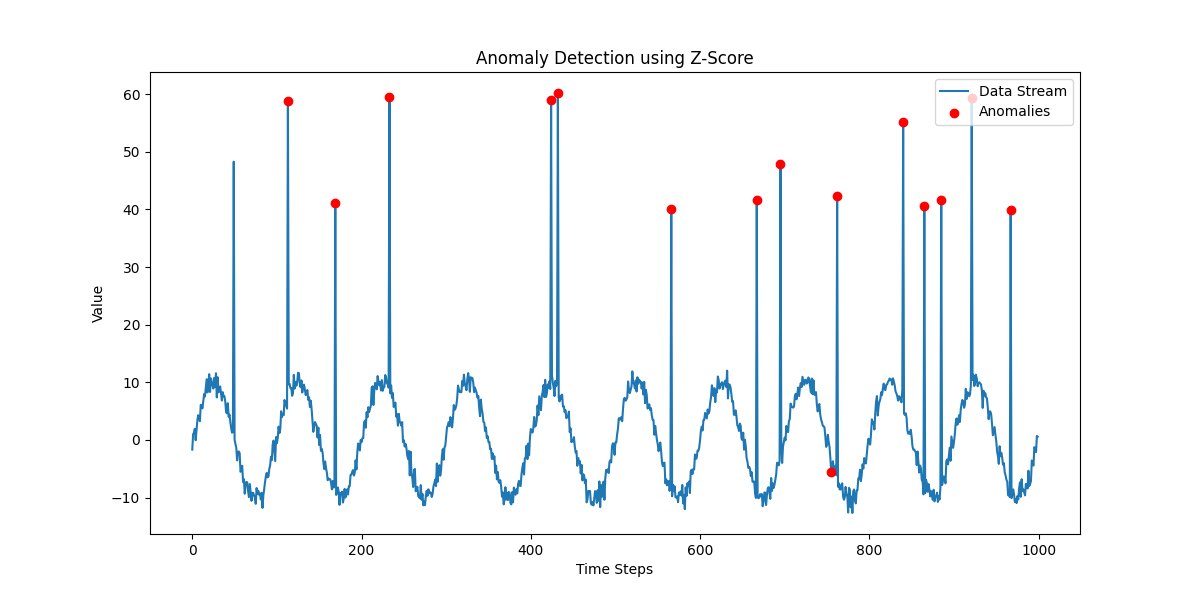

In [18]:
data_stream = generate_data_stream(1000)
zscore_anoms = detect_anomalies_zscore(data_stream)
visualize_anomalies_static(data_stream, zscore_anoms, "Z-Score")

In [11]:
%matplotlib widget

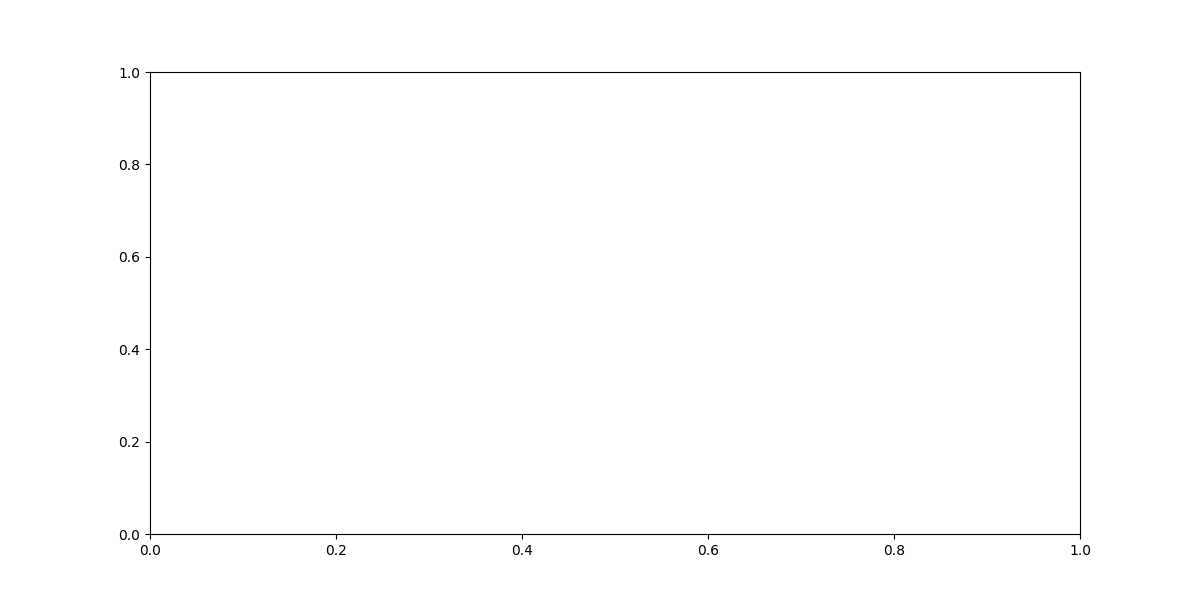

In [20]:
# Save the animation object so it's not deleted
ani = visualize_anomalies(data_stream, zscore_anoms, "Z-score Method")